# Trabajo Práctico N° 3

El objetivo de este trabajo práctico es implementar modelos de regresión categórica que nos permita resolver problemas de clasificación.

Para ello utilizaremos un dataset "propio", es decir, fue seleccionado por los integrantes de nuestro.

El dataset elegido fue una base de datos de estudios de Resonancia Magnética correspondiente a clientes de la empresa Canon Medical Systems Argentina.

Estos datos describen los estudios realizados por el resonador magnético indicando distintas características del mismo como:

- Fecha/Hora
- Duración
- Región Anatómica a la que corresponde
- Bobina de Radiofrecuencia Utilizada
- Tiempo de Respuesta (RT)
- TIempo de Estimulación (RE)
- Campo de Visión (FOV)

La variable target elegida es la de **Región Anatómica**.

La lógica implentada es que según la región del cuerpo que se quiere estudiar (cabeza, tórax, muñeca, rodilla) van a variar distintos parámetros correspondientes al estudio como: tiempo de duración del mismo, tipo de bobina utilizado, campo de visión, plano de reconstrucción, tamaño de píxeles de la matriz de reconstrucción, etc.


## 0- Importación de Librerias 

In [30]:
#Importacion de librerias/módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option("display.max_columns", None)


## 1- Lectura/Análisis Inicial de los datos

### Leemos el dataset de un archivo .csv

In [31]:
#Establezco la dirección del archivo
file_location="datos_TP3.csv"

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location, index_col=0)
datos_crudos=datos_crudos.sample(30000, random_state=1)


### Visualizamos los primeros registros del mismo. Desplegando todas las columnas

In [32]:
#Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

datos_crudos.sample(10)

,Study,No,Start,Scan ID,Mode,Scan Comment,Anatomy,PatientOrient,RcCoil,TxCoil,ContrastName,Plane,Sequence,Option,ScanMode,Time,TR,TE,FA,NS,ST,Gap,FOV,MTX,NAQ,BW,NoWrap,Options,Fltr,Gate,Coverages,Dynamic,SORS,FAT,MTC,Date,Site_ID,Site Name
76839,22396.8455,23,14:47,3D AX T1 FATSA,(B),3D AX T1 FATSAT,Pelvis,F:S,BODY,WB,NaN,AXo:AP,FFE3D,NaN,(B),00:48,4,1.9/+0(1),13,100,4.0,NaN,30.0 x 35.0,164 x 192,1.0,488,NaN,NaN,GA42,NaN,1,OFF,NaN,ON,OFF,2022-10-21,8631,Hospital Español de Mendoza
30683,10123.8723,4,08:53,T2WI STIR,(A),AX T2WI STIR,Hand,H:S,16M-A,WB,NaN,Oth:Oth,FSE2D+7.5,NaN,(A),01:28,3250,60,90/160,12,4.0,0.2,16.0 x 20.0,192 x 256,3.0,326,NaN,NaN,GA52,NaN,1,OFF,NaN,OFF,OFF,2022-10-03,8629,Sanatorio Franchin
82400,29261.8193,5,23:33,T2WI,(A),CO T2WI,Ankle,F:S,FLEXS-4C,WB,NaN,Oth:Oth,FSE2D+12,NaN,(A),03:00,4000,84,90/160,23,3.0,1.0,18.0,288 x 304,1.0,163,PE,NaN,GA41,NaN,1,OFF,NaN,OFF,OFF,2022-08-05,8632,IRSA Jujuy
80076,22653.8455,5,14:27,T2WI,(A),AX T2WI,TL-Spine,F:S,OSP-A,WB,NaN,Oth:Oth,FSE2D+10,:fcSS,(A),03:57,6062,120,90/160,24,4.0,1.0,18.0,224 x 288,2.0,244,PE/RO,:fcSS,GA54,NaN,1,OFF,NaN,OFF,OFF,2022-11-04,8631,Hospital Español de Mendoza
122418,41393.8380,6,13:35,CO T2WI,(A),T2WI,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+10,NaN,(A),01:09,4057,100,90/160,20,6.0,1.2,23.0,320 x 352,1.0,195,NaN,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-09-12,8633,Sanatorio Juncal
19516,9169.8723,0,20:23,Locator SG,(C),Locator SG,TL-Spine,H:S,OSP-A,WB,NaN,SG:AP,FE_crt,NaN,(C),00:05,35,4,25,3,8.0,2.0,40.0,128 x 256,1.0,488,NaN,NaN,NL2,NaN,1,OFF,NaN,OFF,OFF,2022-08-12,8629,Sanatorio Franchin
129633,42006.8380,16,13:55,Shimming,(AB),iAAS_ChestAbdomen,Abdomen,H:S,BODY,WB,NaN,AX:AP,FE_AAS,AAS,(AB),00:07,200,4.8/9.6,70,15,5.0,30.0,49.5,32,1.0,488,NaN,AAS,NONE,NaN,1,OFF,NaN,OFF,OFF,2022-10-03,8633,Sanatorio Juncal
42876,39564.8113,9,16:47,T2WI,(A),AX T2WI,TL-Spine,H:S,OHB-A,WB,NaN,Oth:Oth,FSE2D+10,:fcSS,(A),03:13,5828,120,90/160,24,3.5,0.7,20.0,256,2.0,244,PE/RO,:fcSS,GA53,NaN,1,OFF,NaN,OFF,OFF,2022-08-16,8630,Clinica Pequeña Familia
18927,9119.8723,13,23:02,CO Real IR 3mm,NaN,CO Real IR 3mm,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+18,NaN,NaN,03:50,2799,18,90/160,23,3.3,0.3,20.0 x 18.0,160 x 240,1.0,98,PE,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-08-10,8629,Sanatorio Franchin
48450,40099.8113,9,09:35,iAAS_Head_HEAD,(A),Shimming,Head,H:S,OHD-A,WB,NaN,AX:AP,FE_AAS,NaN,(A),00:13,200,4.8/9.6,70,15,5.0,12.5,36.3,64,1.0,488,NaN,NaN,NL4,NaN,1,OFF,NaN,OFF,OFF,2022-09-13,8630,Clinica Pequeña Familia


### Verificamos la calidad de columnas en cuanto valores nulos

In [33]:
#Ordenando de mayor a menor por porcentaje de valores nulos en cada columna
datos_crudos.isna().sum().sort_values(ascending=False)/datos_crudos.shape[0]*100

SORS             99.623333
Gate             99.290000
ContrastName     96.456667
Options          82.276667
Option           82.276667
NoWrap           45.213333
ScanMode          9.186667
Mode              9.186667
Gap               4.923333
Scan Comment      3.803333
MTX               0.000000
NAQ               0.000000
BW                0.000000
Fltr              0.000000
Study             0.000000
FOV               0.000000
Dynamic           0.000000
FAT               0.000000
MTC               0.000000
Date              0.000000
Site_ID           0.000000
Coverages         0.000000
NS                0.000000
ST                0.000000
No                0.000000
FA                0.000000
TE                0.000000
TR                0.000000
Time              0.000000
Sequence          0.000000
Plane             0.000000
TxCoil            0.000000
RcCoil            0.000000
PatientOrient     0.000000
Anatomy           0.000000
Scan ID           0.000000
Start             0.000000
S

### Removemos aquellas columnas que son redundantes y/o tiene altos valores de porcentajes nulos

In [34]:
# Drop Columnas redundantes y que tienen gran cantidad de Nans
datos=datos_crudos.drop(columns=["SORS", "Gate", "ContrastName", "Options", "Option", "NoWrap", "Site_ID", "Date","Site Name"])

### Ahora damos de la baja las filas donde haya valores nulos

In [35]:
# Drop filas con Nans restantes
datos.dropna(axis=0, inplace=True)

### Verificamos las posibles categorías de la variable target "Región Anatómica"

In [36]:
datos.Anatomy.value_counts(normalize=True)*100

Head         25.051522
TL-Spine     19.300888
Extremity    18.995720
Abdomen      10.799778
Shoulder      7.248732
Pelvis        6.717660
C-Spine       6.709734
Ankle         2.429455
Hand          1.406944
Chest         1.299937
???           0.039632
Name: Anatomy, dtype: float64

In [37]:
# Elimino las filas con target "???""
datos = datos[datos['Anatomy'] != "???"]

## Descripción de Columnas Features:

- PatientOrient: Orientación del paciente dentro del gantry.
- RcCoil: Bobina de Radiofrecuencia.
- TxCoil: Bobina de Transmisión.
- Plane: Plano del estudio.
- Sequence: Tipo de secuencia del estudio.
- Time: Tiempo de duración en minutos de la secuencia.
- TR(Repetition Time)
- TE(Echo Time)
- FA
- NS
- ST
- Gap
- FOV
- MTX
- NAQ


## 3-Implementación de Modelos

### Definimos la matriz de features y el vector target

In [38]:
#Matriz de Features
X = datos[['PatientOrient','RcCoil','TxCoil','Plane','Sequence','Time','TR','TE','FA','NS','ST','Gap','FOV','MTX','NAQ']]

#Vector Target
y = datos.Anatomy



In [39]:
categorical = X.select_dtypes("object").columns

### Separamos los datos en Train y Test

In [40]:
#Train y split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### Implementamos Dummies para las variables categóricas

In [41]:
from sklearn.preprocessing import OneHotEncoder 

def dummies_categoricas(categorias, dataframe1, dataframe2):    
        onehot = OneHotEncoder(drop = "first", handle_unknown='ignore')        
        X_enc_fit= onehot.fit_transform(dataframe1).toarray()
        X_enc_trans= onehot.transform(dataframe2).toarray()        
        enc_data_fit = pd.DataFrame(X_enc_fit, columns = onehot.get_feature_names_out())
        enc_data_trans = pd.DataFrame(X_enc_trans, columns = onehot.get_feature_names_out())
        dataframe1 = pd.concat([dataframe1.drop(columns=categorias).reset_index(drop=True), enc_data_fit], axis=1)
        dataframe2 = pd.concat([dataframe2.drop(columns=categorias).reset_index(drop=True), enc_data_trans], axis=1)
        return dataframe1, dataframe2  

In [42]:
X_train, X_test = dummies_categoricas(categorical, X_train, X_test)

c:\Users\jpans\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


###  Escalamos


In [43]:
# Scalar
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler= scaler.transform(X_test)

In [44]:
print(f"Size pre-PCA: {X_train_scaler.shape}")

Size pre-PCA: (20177, 3925)


### Usamos PCA (Principal Component Analysis)

Es una técnica de extracción de características donde combinamos las entradas de una manera específica y podemos eliminar algunas de las variables “menos importantes” manteniendo la parte más importante todas las variables. Como valor añadido, luego de aplicar PCA conseguiremos que todas las nuevas variables sean independientes una de otra.


Decidimos utilizar esta tecnica para disminuir las variables ya que luego de realizar dummies obtenemos un total de 3902 lo que hace difilcutoso la realizacion de los modelos. Mediante este procedimiento se logra reducir las variables y logrando un mejor rendimiento de los modelos.

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)
X_train_scaler = pca.fit_transform(X_train_scaler)
X_test_scaler = pca.transform(X_test_scaler)


In [46]:
print("Número de componentes:", pca.n_components_)


Número de componentes: 2087


In [47]:
print(f"Size post-PCA: {X_train_scaler.shape}")

Size post-PCA: (20177, 2087)


### Definimos una función que evalue los modelos aplicando distintas métricas:

In [48]:
# Funcion para Scores

resultados_fin = pd.DataFrame()

def evaluacion(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

    # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = round(sensibilidad,2)

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = round(accuracy,2)

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = round(precision,2)

    # Calcular F1 score
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')
    resultados['F1 Score'] = round(f1_score,2)

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title(f'Matrix de Confusion {model}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin[model]= resultado_df 
    return resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})

## 3.1 - Regresión Logística

In [49]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, random_state=1)

lr.fit(X_train_scaler, y_train) 

ypred_lr_train = lr.predict(X_train_scaler)
ypred_lr_test = lr.predict(X_test_scaler)


c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


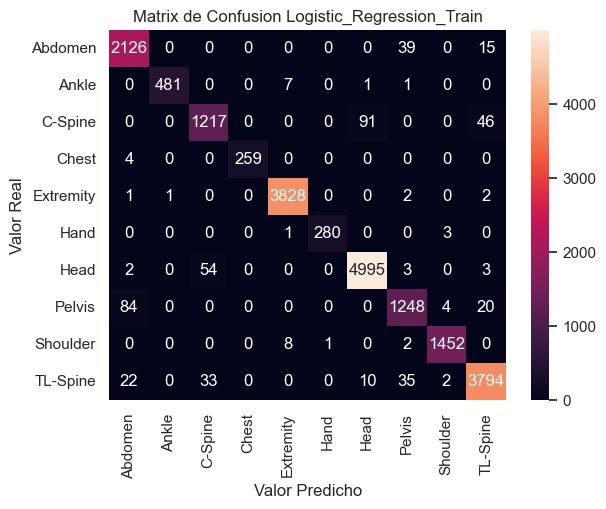

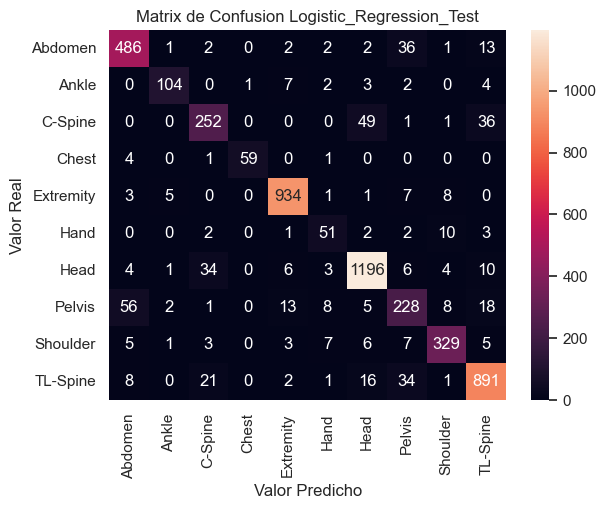

,Logistic_Regression_Train,Logistic_Regression_Test
Sensibilidad,0.97,0.85
Accuracy,0.98,0.90
Precision,0.98,0.86
F1 Score,0.97,0.86


In [50]:
evaluacion(y_train, ypred_lr_train, model="Logistic_Regression_Train")


evaluacion(y_test, ypred_lr_test, model="Logistic_Regression_Test")


## 3.2 - Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_scaler, y_train)


ypred_gnb_train = gnb.predict(X_train_scaler)


ypred_gnb_test = gnb.predict(X_test_scaler)

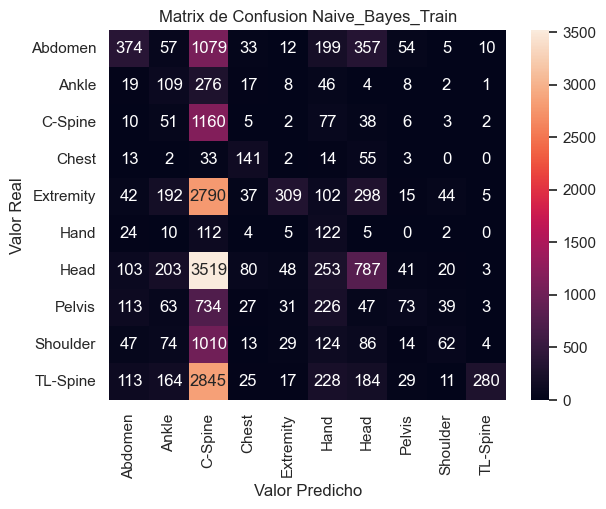

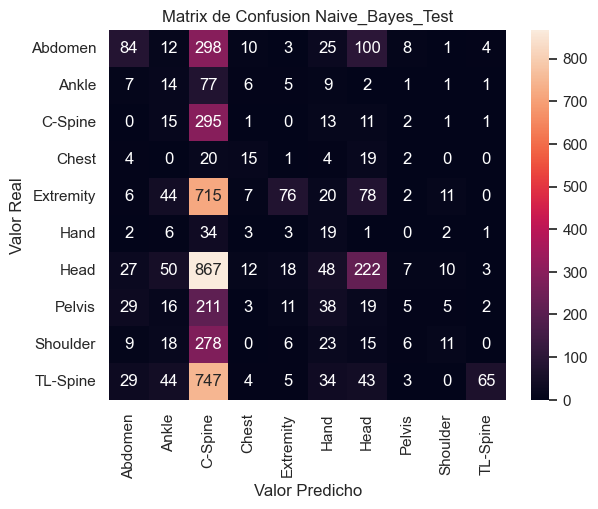

,Logistic_Regression_Train,Logistic_Regression_Test,Naive_Bayes_Train,Naive_Bayes_Test
Sensibilidad,0.97,0.85,0.26,0.20
Accuracy,0.98,0.90,0.17,0.16
Precision,0.98,0.86,0.37,0.32
F1 Score,0.97,0.86,0.18,0.14


In [52]:

evaluacion(y_train, ypred_gnb_train, model="Naive_Bayes_Train")


evaluacion(y_test, ypred_gnb_test, model="Naive_Bayes_Test")

## KNN


In [53]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Hyperparametros
parameters_knn = {"n_neighbors" : list(range(1, 15))}

clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1)
                   

# Fit el modelo ya seleccionado
clf_knn.fit(X_train_scaler, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             verbose=1)

In [54]:
print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_knn.best_params_, clf_knn.best_score_))

Los mejores parametros fueron {'n_neighbors': 3} con un score de 0.84


In [55]:
ypred_knn_train = clf_knn.predict(X_train_scaler)
ypred_knn_test = clf_knn.predict(X_test_scaler)

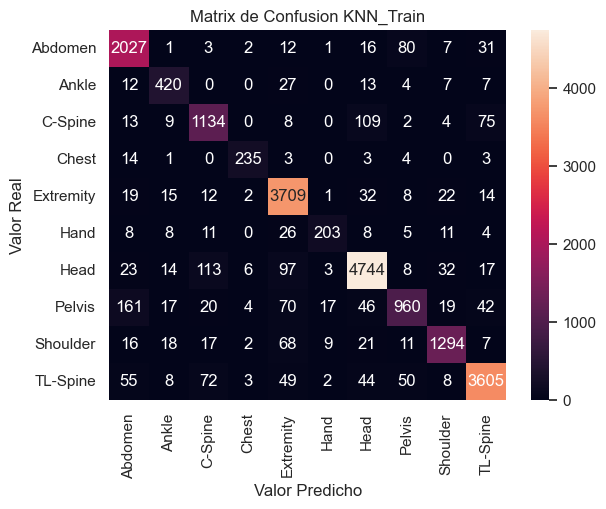

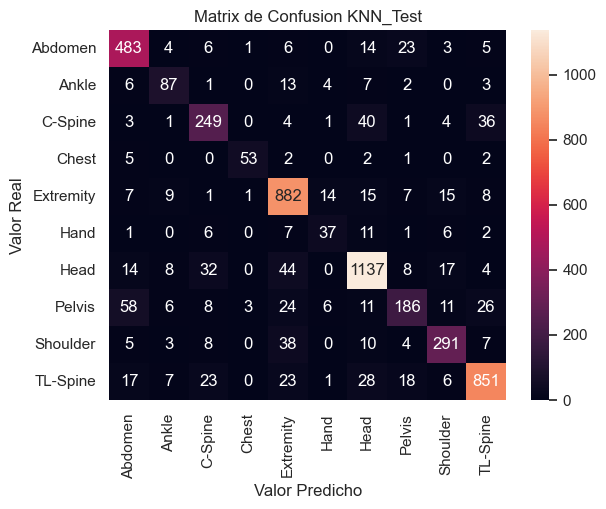

,Logistic_Regression_Train,Logistic_Regression_Test,Naive_Bayes_Train,Naive_Bayes_Test,KNN_Train,KNN_Test
Sensibilidad,0.97,0.85,0.26,0.20,0.87,0.77
Accuracy,0.98,0.90,0.17,0.16,0.91,0.84
Precision,0.98,0.86,0.37,0.32,0.89,0.80
F1 Score,0.97,0.86,0.18,0.14,0.87,0.78


In [56]:

evaluacion(y_train, ypred_knn_train, model="KNN_Train")


evaluacion(y_test, ypred_knn_test, model="KNN_Test")

## Visualizacion


In [ ]:
resultados_fin = resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})
scores_columns= ["Sensibilidad","Accuracy", "Precision", "F1 Score"]

for scores in scores_columns:
    sns.set_context('paper')
    ax = sns.barplot(x =resultados_fin[scores] ,y = "Modelos" ,data = resultados_fin.sort_values(by=scores, ascending=False), palette = 'magma')
    ax.set(xlabel=scores, ylabel="Modelos", title="Comparación de Scores")
    plt.show()